# Load Stuff

In [3]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import cv2
import neural_structured_learning as nsl

In [4]:
classes = {
    0: ("actinic keratoses and intraepithelial carcinomae(Cancer)"),
    1: ("basal cell carcinoma(Cancer)"),
    2: ("benign keratosis-like lesions(Non-Cancerous)"),
    3: ("dermatofibroma(Non-Cancerous)"),
    4: ("melanocytic nevi(Non-Cancerous)"),
    5: ("pyogenic granulomas and hemorrhage(Can lead to cancer)"),
    6: ("melanoma(Cancer)"),
}

In [5]:
# Paths
train_path = "dataset\\hmnist_28_28_RGB_train.csv"
test_path = "dataset\\hmnist_28_28_RGB_test.csv"

comp_train_path = "dataset\\hmnist_28_28_RGB_train_0e055.csv"
comp_test_path = "dataset\\hmnist_28_28_RGB_test_0e055.csv"

# main_model_path = 'adv_trained_model.h5'
main_model_path = 'best_model.h5'
defended_model_path = 'best_model_defended.h5'

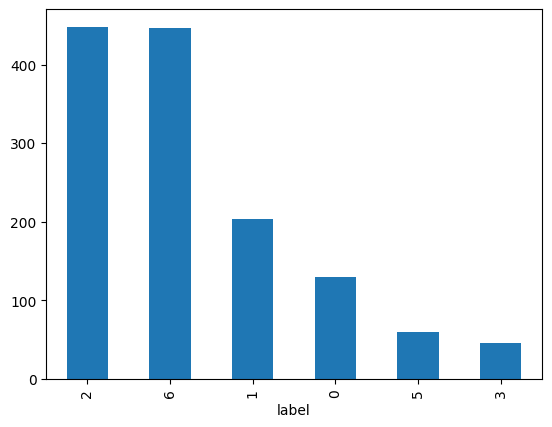

In [27]:
# Load train and test set into X and Y
train_set = pd.read_csv(train_path)
test_set = pd.read_csv(test_path)

label_4_rows = test_set[test_set['label'] == 4]
other_rows = test_set[test_set['label'] != 4]

# Randomly sample half of the rows with label 4
sampled_label_4_rows = label_4_rows.sample(frac=0.5, random_state=42)

# Concatenate the sampled label 4 rows with the other rows
final_test_set = pd.concat([sampled_label_4_rows, other_rows])

# If you want to reset the index of the new DataFrame
final_test_set.reset_index(drop=True, inplace=True)


# save
train_set.to_csv("dataset\\hmnist_28_28_RGB_train_aug.csv", index=False)
test_set.to_csv("dataset\\hmnist_28_28_RGB_test_aug.csv", index=False)

train_set.value_counts('label').plot(kind='bar')

y_train = train_set['label']
x_train = train_set.drop(columns=['label'])
x_train=np.array(x_train).reshape(-1,28,28,3)

y_test = test_set['label']
x_test = test_set.drop(columns=['label'])
x_test=np.array(x_test).reshape(-1,28,28,3)


In [8]:
# Load the pre-trained model
model = keras.models.load_model(main_model_path)
model.trainable = True
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
score = model.evaluate(x_test, y_test, verbose=0, batch_size=1)
print('Test loss:', score[0])
print('Test accuracy (%):', 100*score[1])





Test loss: 1.055915355682373
Test accuracy (%): 71.89216017723083


In [6]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0

# Attack

### Function to Make Pertubated Images 

In [11]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def make_pertubation(image, model_to_attack):
    if len(image.shape) == 3:
        image = tf.convert_to_tensor(image.reshape((1, 28, 28, 3)), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model_to_attack(image)
        label = tf.argmax(prediction, axis=1)
        loss = loss_object(label, prediction)

    gradient = tape.gradient(loss, image)
    perturbations = tf.sign(gradient)

    return perturbations

def create_compromised_image(image, epsilon, model_to_attack):
    if len(image.shape) == 3:
        image = tf.convert_to_tensor(image.reshape((1, 28, 28, 3)), dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model_to_attack(image)
        label = tf.argmax(prediction, axis=1)
        loss = loss_object(label, prediction)

    gradient = tape.gradient(loss, image)
    perturbations = tf.sign(gradient)

    adversarial_image = image + epsilon*make_pertubation(image, model_to_attack)

    # Clip the image to be between 0 and 255
    return tf.clip_by_value(adversarial_image, 0, 255)
    


def iterative_fgsm_attack(image, epsilon, model_to_attack, steps = 5):
    for i in range(steps):
        image = create_compromised_image(image, epsilon, model_to_attack)
    return image

def make_and_store_pertubated_images(og_path, comp_path, epsilon, model = model, attack_function = create_compromised_image):
    og_df=pd.read_csv(og_path)

    labels = og_df['label']
    og_img = og_df.drop(columns=['label'])
    og_img=np.array(og_img).reshape(-1,28,28,3)

    # Create compromised dataset
    compromised_img = []
    epsilon = 0.055
    for i, img in enumerate(og_img):
        adv_x = attack_function(img, epsilon*255, model)[0].numpy()
        compromised_img.append(adv_x)
    compromised_img = np.array(compromised_img)

    # Evaluate compromised dataset
    score = model.evaluate(compromised_img, labels, verbose=0, batch_size=1)
    print('Test loss:', score[0])
    print('Test accuracy (%):', 100*score[1])

    # Save as csv
    compromised_img = compromised_img.reshape(-1, 28*28*3)
    compromised_img_with_labels = np.concatenate((compromised_img, np.array(labels)[:, None]), axis=1)
    comp_df = pd.DataFrame(compromised_img_with_labels)
    comp_df.columns = og_df.columns
    comp_df.to_csv(comp_path, index=False)
    return comp_df


# make_and_store_pertubated_images(train_path, comp_train_path, 0.055, model=model)
# make_and_store_pertubated_images(test_path, comp_test_path, 0.055, model=model)

### Test Out Attack

1/1 [==============================] - 0s 29ms/step


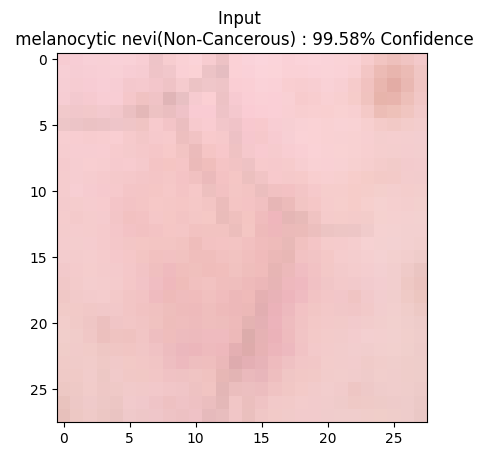

1/1 [==============================] - 0s 28ms/step


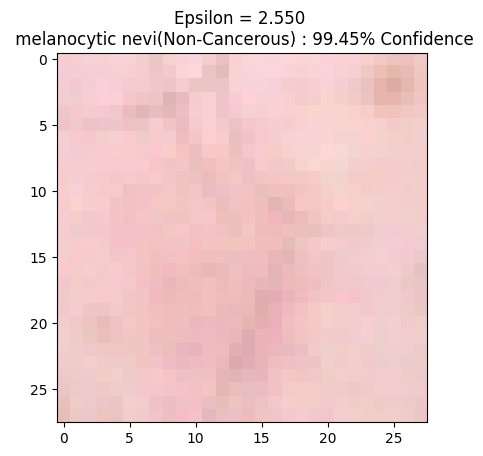

1/1 [==============================] - 0s 30ms/step


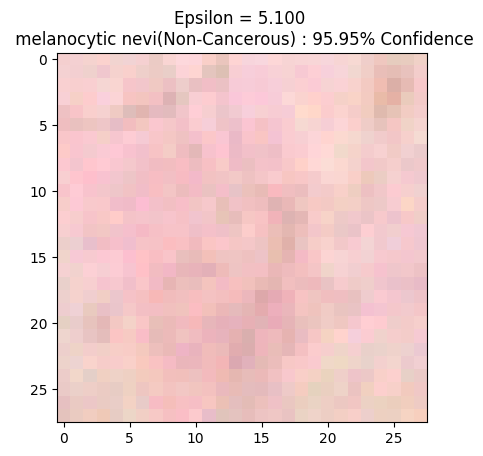

1/1 [==============================] - 0s 25ms/step


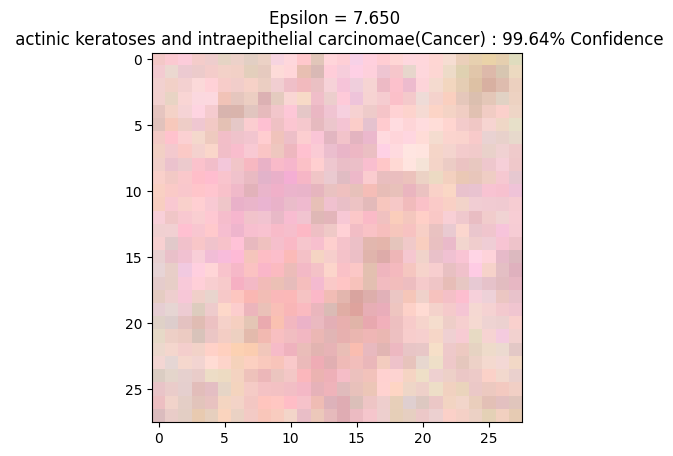

1/1 [==============================] - 0s 32ms/step


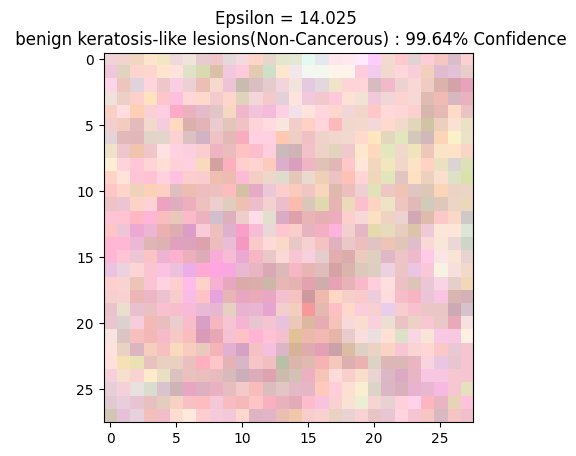

In [33]:
def display_images(new_image, description, model = model):
    #  Display the given image along with its predicted label and confidence.
    pred = model.predict(new_image)
    label = np.argmax(pred, axis=1)[0]
    label = classes[label]
    confidence = np.max(pred, axis=1)[0]
    plt.figure()
    plt.imshow(new_image[0]*0.5/255+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
    plt.show()

epsilons = np.array([0, 0.01, 0.02, 0.03, 0.055])*255
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]

denoise_model = keras.models.load_model('AE_denosing.h5')
classifying_model = keras.models.load_model('best_model.h5')

# Merge Models
merged_model = keras.models.Sequential()
merged_model.add(denoise_model)
merged_model.add(classifying_model)

for i, eps in enumerate(epsilons):
    adv_x = iterative_fgsm_attack(x_test[0], eps, merged_model)
    display_images(adv_x, descriptions[i])

### Test Attack on multiple images and plot the accuracy for different epsilons

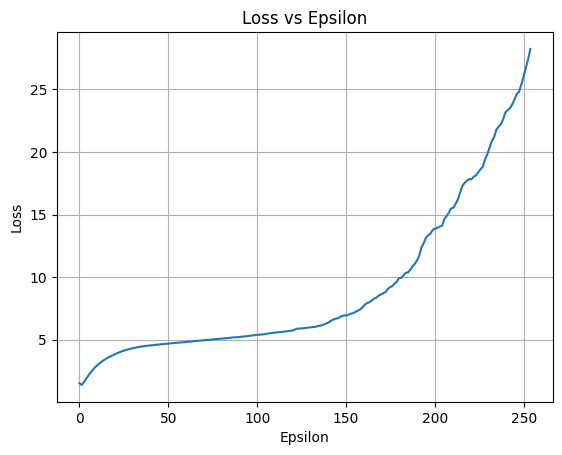

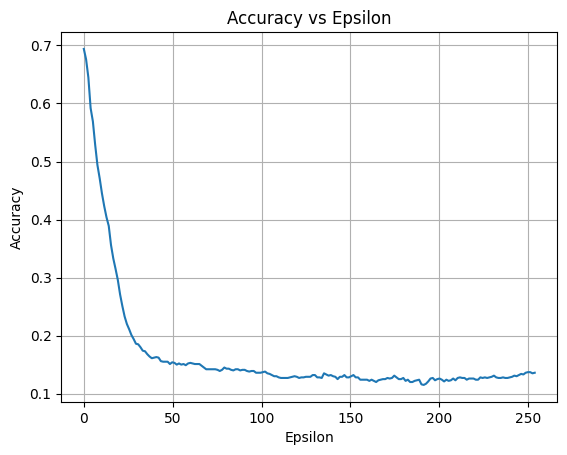

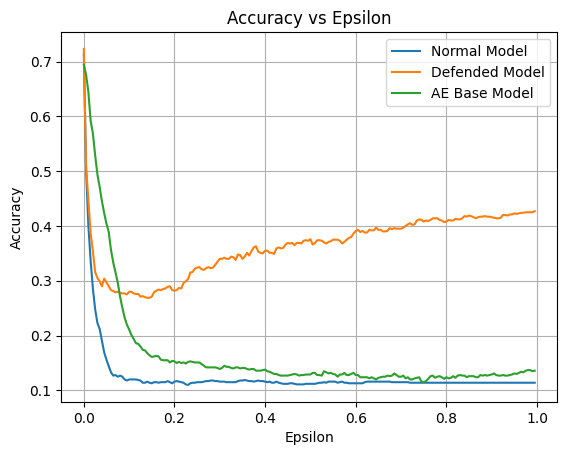

In [25]:
def epsilon_iter_attack(epsilon, dataset, model, length = 20, save = False, path = 'epsilon_iter_attack.csv'):
    test_loss = []
    test_acc = []

    pertubations = np.array([make_pertubation(img, model) for img in dataset[:length]])

    for eps in epsilon:
        x_test_compromised = []
        for i, img in enumerate(dataset[:length]):
            adv_x = (img.reshape((1, 28, 28, 3)) + eps*pertubations[i])[0]
            x_test_compromised.append(adv_x)

        x_test_compromised = np.array(x_test_compromised)
        score = model.evaluate(x_test_compromised, y_test[:length], verbose=0, batch_size=1)
        test_loss.append(score[0])
        test_acc.append(score[1])
    
    if save:
        # Save loss and accuracy as csv
        df = pd.DataFrame({'Epsilon': epsilon, 'Loss': test_loss, 'Accuracy': test_acc})
        df.to_csv(path, index=False)
    return test_loss, test_acc

epsilon = np.arange(0, 1, 0.005)*255

# model = keras.models.load_model('best_model.h5')
# test_loss, test_acc = epsilon_iter_attack(epsilon, x_test, length=1000, model=model, save=True, path='normal.csv')

# plt.figure()
# plt.plot(epsilon, test_loss)
# plt.title('Loss vs Epsilon')
# plt.xlabel('Epsilon')
# plt.ylabel('Loss')
# plt.grid()
# plt.show()

# plt.figure()
# plt.plot(epsilon, test_acc)
# plt.title('Accuracy vs Epsilon')
# plt.xlabel('Epsilon')
# plt.ylabel('Accuracy')
# plt.grid()
# plt.show()


# defended_model = keras.models.load_model('best_model_defended.h5')
# test_loss, test_acc = epsilon_iter_attack(epsilon, x_test, length=1000, model=defended_model, save=True, path='defended.csv')

# plt.figure()
# plt.plot(epsilon, test_loss)
# plt.title('Loss vs Epsilon')
# plt.xlabel('Epsilon')
# plt.ylabel('Loss')
# plt.grid()
# plt.show()

# plt.figure()
# plt.plot(epsilon, test_acc)
# plt.title('Accuracy vs Epsilon')
# plt.xlabel('Epsilon')
# plt.ylabel('Accuracy')
# plt.grid()
# plt.show()


denoise_model = keras.models.load_model('AE_denosing_2.h5')
classifying_model = keras.models.load_model('best_model.h5')
merged_model = keras.models.Sequential()
merged_model.add(denoise_model)
merged_model.add(classifying_model)
merged_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
test_loss, test_acc = epsilon_iter_attack(epsilon, x_test, length=1000, model=merged_model, save=True, path='AE_base.csv')



plt.figure()
plt.plot(epsilon, test_loss)
plt.title('Loss vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Loss')
plt.grid()
plt.show()

plt.figure()
plt.plot(epsilon, test_acc)
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.grid()
plt.show()


# Load csvs
normal = pd.read_csv('normal.csv')
defended = pd.read_csv('defended.csv')
AE_base = pd.read_csv('AE_base.csv')

# Plot all in same figure
plt.figure()
plt.plot(normal['Epsilon']/255.0, normal['Accuracy'], label='Normal Model')
plt.plot(defended['Epsilon']/255.0, defended['Accuracy'], label='Defended Model')
plt.plot(AE_base['Epsilon']/255.0, AE_base['Accuracy'], label='AE Base Model')
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

# Defence

### Load and Mix Pertubated Images With Normal images

In [8]:
og_train_df = pd.read_csv(train_path)
comp_train_df = pd.read_csv(comp_train_path)

og_test_df = pd.read_csv(test_path)
comp_test_df = pd.read_csv(comp_test_path)


# Merge the two datasets
merged_train_df = pd.concat([og_train_df, comp_train_df], ignore_index=True)
merged_test_df = pd.concat([og_test_df, comp_test_df], ignore_index=True)

# Shuffle the datasets
merged_train_df = merged_train_df.sample(frac=1).reset_index(drop=True)
merged_test_df = merged_test_df.sample(frac=1).reset_index(drop=True)

# Print the number of samples in each dataset
print("Number of samples in train set: {}".format(len(merged_train_df)))
print("Number of samples in test set: {}".format(len(merged_test_df)))

# Prepare images and labels
y_train_merged = merged_train_df['label']
x_train_merged = merged_train_df.drop(columns=['label'])

y_test_merged = merged_test_df['label']
x_test_merged = merged_test_df.drop(columns=['label'])

y_test_compromised = comp_test_df['label']
x_test_compromised = comp_test_df.drop(columns=['label'])

# Oversample the train set
oversample = RandomOverSampler()
x_train_merged,y_train_merged  = oversample.fit_resample(x_train_merged,y_train_merged)

# Reshape the train and test sets
x_train_merged = np.array(x_train_merged).reshape(-1,28,28,3)
x_test_merged = np.array(x_test_merged).reshape(-1,28,28,3)
x_test_compromised = np.array(x_test_compromised).reshape(-1,28,28,3)

Number of samples in train set: 16024
Number of samples in test set: 4006


### Adversarial Training

In [11]:
# Copy the model
model_defended = keras.models.clone_model(model)
model_defended.set_weights(model.get_weights())

# Compile the model
model_defended.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_defended.fit(x_train_merged, y_train_merged, epochs=10, batch_size=32, validation_data=(x_test_merged, y_test_merged))

# Evaluate the model
score = model_defended.evaluate(x_test_compromised, y_test_compromised, verbose=0, batch_size=1)
model_defended.save(defended_model_path)
print(score)

[1.8303314447402954, 0.6884673237800598]


In [21]:
adv_config = nsl.configs.make_adv_reg_config(multiplier=0.5, adv_step_size=0.2, adv_grad_norm='infinity')
adv_model = nsl.keras.AdversarialRegularization(model, label_keys=['label'], adv_config = adv_config)


adv_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


adv_model.fit({'feature': x_train, 'label': y_train}, epochs=5)


# adv_model = keras.models.load_model(defended_model_path)

score = adv_model.evaluate({'feature': x_train, 'label': y_train})

print('Train loss:', score[0])
print('Train accuracy (%):', 100*score[1])

Epoch 1/5


251/251 [==============================] - 26s 29ms/step - loss: 0.6102 - sparse_categorical_crossentropy: 0.4086 - sparse_categorical_accuracy: 0.8781 - scaled_adversarial_loss: 0.2016
Epoch 2/5
251/251 [==============================] - 7s 29ms/step - loss: 0.3625 - sparse_categorical_crossentropy: 0.2397 - sparse_categorical_accuracy: 0.9217 - scaled_adversarial_loss: 0.1227
Epoch 3/5
251/251 [==============================] - 7s 28ms/step - loss: 0.3049 - sparse_categorical_crossentropy: 0.2020 - sparse_categorical_accuracy: 0.9319 - scaled_adversarial_loss: 0.1029
Epoch 4/5
251/251 [==============================] - 7s 28ms/step - loss: 0.3094 - sparse_categorical_crossentropy: 0.2038 - sparse_categorical_accuracy: 0.9330 - scaled_adversarial_loss: 0.1055
Epoch 5/5
251/251 [==============================] - 5s 11ms/step - loss: 0.1491 - sparse_categorical_crossentropy: 0.0994 - sparse_categorical_accuracy: 0.9654 - scaled_adversarial_loss: 0.0497
Train loss: 0.14914202690124512
Tr

### Filter Input Defence

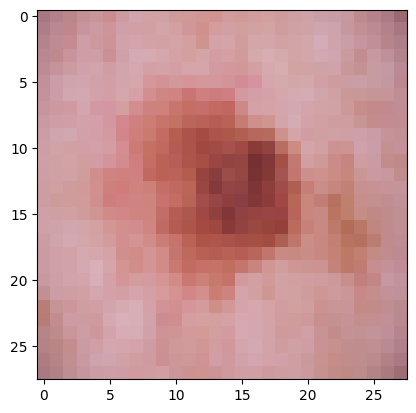

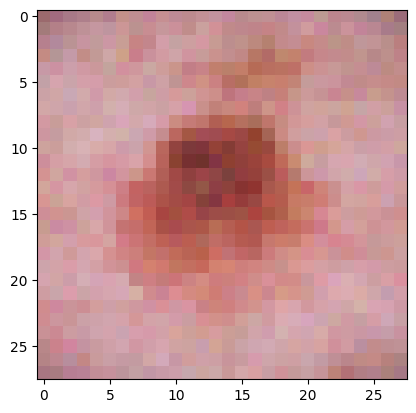

In [95]:
def preprocess_img(img):
    # Add Gaussian noise
    noise = np.random.normal(0, 1, img.shape)
    img = img + noise*5

    # Roate image randomly
    angle = np.random.randint(1, 4)
    img = np.rot90(img, angle)

    # convert array elements from floats to ints
    img = img.astype(np.uint8)
    return img

new_img = preprocess_img(x_train[0])

plt.imshow(x_train[0])
plt.show()

plt.imshow(new_img)
plt.show()

### Denoising with AEs

In [24]:
denoise_model = keras.models.load_model('AE_denosing_2.h5')
classifying_model = keras.models.load_model('best_model.h5')

# Merge Models
merged_model = keras.models.Sequential()
merged_model.add(denoise_model)
merged_model.add(classifying_model)

merged_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# make_and_store_pertubated_images('dataset/hmnist_28_28_RGB_train.csv', 'dataset/hmnist_28_28_RGB_train_AE.csv', 0.055, model=merged_model)
make_and_store_pertubated_images('dataset/hmnist_28_28_RGB_test.csv', 'dataset/hmnist_28_28_RGB_test_AE.csv', 0.055, model=merged_model)

AE_comp_df = pd.read_csv('dataset/hmnist_28_28_RGB_test_AE.csv')
y_test_compromised_AE = AE_comp_df['label']
x_test_compromised_AE = AE_comp_df.drop(columns=['label'])
x_test_compromised_AE = np.array(x_test_compromised_AE).reshape(-1,28,28,3)

score = merged_model.evaluate(x_test_compromised_AE, y_test_compromised_AE, verbose=0, batch_size=1)
print('Test loss:', score[0])
print('Test accuracy (%):', 100*score[1])

Test loss: 3.3624446392059326
Test accuracy (%): 39.14128839969635
Test loss: 3.3624446392059326
Test accuracy (%): 39.14128839969635


### Test Defended Model 

In [96]:
# print('Original dataset:')
# score_og = model.evaluate(x_test, y_test, verbose=0, batch_size=1)
# score_defend = defended_model.evaluate(x_test, y_test, verbose=0, batch_size=1)
# score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
# print(score_df)

defended_model = keras.models.load_model(defended_model_path)

y_test_compromised = comp_test_df['label']
x_test_compromised = comp_test_df.drop(columns=['label'])
x_test_compromised = np.array(x_test_compromised).reshape(-1,28,28,3)
print('\nCompromised dataset:')
score_og = model.evaluate(x_test_compromised, y_test_compromised, verbose=0, batch_size=1)
score_defend = defended_model.evaluate(x_test_compromised, y_test_compromised, verbose=0, batch_size=1)
score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
print(score_df)

# Add random noise to the compromised dataset
x_test_compromised_filtered = np.array([preprocess_img(img) for img in x_test_compromised])
print('\nCompromised dataset filtered:')
score_og = model.evaluate(x_test_compromised_filtered, y_test_compromised, verbose=0, batch_size=1)
score_defend = defended_model.evaluate(x_test_compromised_filtered, y_test_compromised, verbose=0, batch_size=1)
score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
print(score_df)


# rot_img = np.array([np.rot90(img, 2) for img in x_test_compromised])
# print('\nCompromised dataset rotated 180 deg:')
# score_og = model.evaluate(rot_img, y_test_compromised, verbose=0, batch_size=1)
# score_defend = defended_model.evaluate(rot_img, y_test_compromised, verbose=0, batch_size=1)
# score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
# print(score_df)


# print('\nMerged dataset:')
# score_og = model.evaluate(x_test_merged, y_test_merged, verbose=0, batch_size=1)
# score_defend = defended_model.evaluate(x_test_merged, y_test_merged, verbose=0, batch_size=1)
# score_df = pd.DataFrame({'Original': score_og, 'Defended': score_defend}, index=['Loss', 'Accuracy'])
# print(score_df)


Compromised dataset:
          Original  Defended
Loss      4.622623  1.830331
Accuracy  0.137294  0.688467

Compromised dataset filtered:
          Original  Defended
Loss      2.147942  2.144295
Accuracy  0.474788  0.529705
